# Multimodal dataset embeddings generation & visualization

In [210]:
# Importing required libraries
import torch
import pandas as pd
from torch.utils.data import Dataset, DataLoader  # Modified
from transformers import BertModel, BertTokenizer
from torchvision.models import resnet50
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import os
from tqdm import tqdm
import re  # Added for path normalization
from pathlib import Path

## setting up device configuration

In [211]:
# Setting up Configuration
class Config:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    text_embed_dim = 768
    image_embed_dim = 2048
    embed_save_dir = "./embeddings/"
    batch_size = 32  # Added for DataLoader

os.makedirs(Config.embed_save_dir, exist_ok=True)

In [212]:
# Using the MultiModalDataset class defined in the notebook 4
class MultiModalDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        
        # Load pre-saved tensors from files
        input_ids = torch.load(os.path.join("dataset", row["input_ids"])).squeeze(0)
        attention_mask = torch.load(os.path.join("dataset", row["attention_mask"])).squeeze(0)
        
        # Load image
        image = torch.load(row["transformed_image_path"])
        
        # Labels
        labels = torch.tensor(row["labels"], dtype=torch.float)
        
        return input_ids, attention_mask, image, labels


## Loading transformed dataset

In [213]:
# Load prepared dataset
clean_data = pd.read_csv("dataset/dataset_transformed.csv")
clean_data["transformed_image_path"] = clean_data["transformed_image_path"].str.replace("\\", "/", regex=False)  # Critical fix
clean_data["labels"] = clean_data["labels"].apply(eval)


# Verify data
print(f"Dataset size: {len(clean_data)}")
clean_data.head()

Dataset size: 50


,tweet_text,image_path,labels,input_ids,attention_mask,transformed_image_path
0,nigga,dataset/images/0.jpg,"[0, 1, 0, 1, 1, 0]",input_ids/0.pt,attention_masks/0.pt,dataset/transformed_images/0.pt
1,my horses are retarded,dataset/images/1.jpg,"[0, 0, 0, 0, 0, 1]",input_ids/1.pt,attention_masks/1.pt,dataset/transformed_images/1.pt
2,nigga on ma momma youngboy be spitting real sh...,dataset/images/2.jpg,"[1, 0, 0, 0, 0, 0]",input_ids/2.pt,attention_masks/2.pt,dataset/transformed_images/2.pt
3,rt xxsugvngxx i ran into this holy nigga today,dataset/images/3.jpg,"[1, 1, 0, 0, 0, 0]",input_ids/3.pt,attention_masks/3.pt,dataset/transformed_images/3.pt
4,everybody calling you nigger now,dataset/images/4.jpg,"[1, 1, 0, 0, 0, 0]",input_ids/4.pt,attention_masks/4.pt,dataset/transformed_images/4.pt


## Initializing embedding models

In [214]:
# Initialize models
text_encoder = BertModel.from_pretrained('bert-base-uncased').to(Config.device)
image_encoder = resnet50(pretrained=True)
image_encoder = torch.nn.Sequential(*(list(image_encoder.children())[:-1])).to(Config.device)

# Freeze with device awareness
for model in [text_encoder, image_encoder]:
    model.eval()
    for param in model.parameters():
        param.requires_grad = False

c:\Users\100ab\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\100ab\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### generating embeddings

In [215]:
# Batch Embedding Generation

def generate_batch_embeddings(batch):
    """Process batch from DataLoader with dimension validation"""
    input_ids, attn_mask, images, labels = batch
    
    # Validate dimensions
    assert input_ids.dim() == 2, f"Input IDs should be 2D [B, 128], got {input_ids.shape}"
    assert attn_mask.dim() == 2, f"Attention mask should be 2D [B, 128], got {attn_mask.shape}"
    
    # Move to device
    input_ids = input_ids.to(Config.device)
    attn_mask = attn_mask.to(Config.device)
    images = images.to(Config.device)
    
    # Text embeddings
    with torch.no_grad():
        text_outputs = text_encoder(
            input_ids=input_ids,
            attention_mask=attn_mask
        )
        text_embeds = text_outputs.last_hidden_state[:, 0, :]
    
    # Image embeddings
    with torch.no_grad():
        image_embeds = image_encoder(images)
        image_embeds = image_embeds.flatten(1)
    
    multimodal_embeds = torch.cat([text_embeds, image_embeds], dim=1)
    
    return (
        text_embeds.cpu(), 
        image_embeds.cpu(), 
        multimodal_embeds.cpu(), 
        labels.cpu()
    )

In [216]:
# type: ignore[no-unicode]

"""
# Embedding generation
def generate_embeddings(text, image_path):
    # Text embedding
    inputs = tokenizer(text, return_tensors="pt", 
                      padding="max_length", 
                      truncation=True, 
                      max_length=128).to(Config.device)
    
    with torch.no_grad():
        text_embed = text_encoder(**inputs).last_hidden_state[:,0,:].cpu().squeeze(0)  # [768]
        
    # Image embedding
    image_tensor = torch.load(image_path).to(Config.device)
    with torch.no_grad():
        image_embed = image_encoder(image_tensor.unsqueeze(0))  # [1, 2048, 1, 1]
        image_embed = image_embed.flatten().cpu()  # [2048]
    
    # Ensure both are 1D tensors before concatenation
    text_embed = text_embed.squeeze()  # [768]
    image_embed = image_embed.squeeze()  # [2048]
    
    return {
        'text_embed': text_embed,
        'image_embed': image_embed,
        'multimodal_embed': torch.cat([text_embed, image_embed])  # [2816]
    }
"""

'\n# Embedding generation\ndef generate_embeddings(text, image_path):\n    # Text embedding\n    inputs = tokenizer(text, return_tensors="pt", \n                      padding="max_length", \n                      truncation=True, \n                      max_length=128).to(Config.device)\n    \n    with torch.no_grad():\n        text_embed = text_encoder(**inputs).last_hidden_state[:,0,:].cpu().squeeze(0)  # [768]\n        \n    # Image embedding\n    image_tensor = torch.load(image_path).to(Config.device)\n    with torch.no_grad():\n        image_embed = image_encoder(image_tensor.unsqueeze(0))  # [1, 2048, 1, 1]\n        image_embed = image_embed.flatten().cpu()  # [2048]\n    \n    # Ensure both are 1D tensors before concatenation\n    text_embed = text_embed.squeeze()  # [768]\n    image_embed = image_embed.squeeze()  # [2048]\n    \n    return {\n        \'text_embed\': text_embed,\n        \'image_embed\': image_embed,\n        \'multimodal_embed\': torch.cat([text_embed, image_em

In [217]:
# Dataloader setup from Notebook 4

dataset = MultiModalDataset(clean_data)
dataloader = DataLoader(
    dataset,
    batch_size=Config.batch_size,
    shuffle=False,  # Critical for ordered saving
)


### saving embeddings final

In [218]:
# Batch Processing Loop & Saving final embeddings

# Embeddings processing and saving - Enhanced Version
def save_embeddings_batch(batch_idx, embeddings_dict):
    """Universal saving function with proper validation"""
    try:
        # Validate embeddings before saving
        assert len(embeddings_dict['text']) > 0, "Cannot save empty batch"
        
        # Convert lists of tensors to stacked tensors
        saved_data = {
            'text': torch.stack(embeddings_dict['text']),
            'image': torch.stack(embeddings_dict['image']),
            'multimodal': torch.stack(embeddings_dict['multimodal']),
            'labels': torch.stack(embeddings_dict['labels'])
        }
        
        # Save with both batch index and sample count
        sample_count = saved_data['text'].shape[0]
        filename = f"{Config.embed_save_dir}embeddings_{batch_idx:04d}_{sample_count}samples.pt"
        torch.save(saved_data, filename)
        return True
    except Exception as e:
        print(f"Failed to save batch {batch_idx}: {str(e)}")
        return False

# Initialize storage with progress tracking
embeddings_dict = {
    'text': [],
    'image': [],
    'multimodal': [],
    'labels': []
}
saved_samples = 0

for batch_idx, (input_ids, attn_mask, images, labels) in enumerate(tqdm(dataloader)):
    try:
        """
        # Batch processing (from DataLoader version)
        input_ids = torch.stack(batch[0])
        attn_mask = torch.stack(batch[1])
        images = torch.stack(batch[2])
        labels = torch.stack(batch[3])
        """
        
        text, image, mm, labels = generate_batch_embeddings(
            (input_ids, attn_mask, images, labels)
        )
        
        # Store embeddings
        embeddings_dict['text'].extend(text)
        embeddings_dict['image'].extend(image)
        embeddings_dict['multimodal'].extend(mm)
        embeddings_dict['labels'].extend(labels)
        
        # Saving 
        current_samples = len(embeddings_dict['text'])
        if current_samples >= 1000 or (batch_idx == len(dataloader)-1):
            if save_embeddings_batch(batch_idx, embeddings_dict):
                saved_samples += current_samples
                embeddings_dict = {k: [] for k in embeddings_dict}
                       
    except Exception as e:
        print(f"Batch {batch_idx} failed: {str(e)}")
        continue

# Final save with validation
if any(len(v) > 0 for v in embeddings_dict.values()):
    save_embeddings_batch('final', embeddings_dict)
    print(f"Saved final batch with {len(embeddings_dict['text'])} samples")
else:
    print(f"Total saved samples: {saved_samples}")

print("Saved files:", os.listdir(Config.embed_save_dir))

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:43<00:00, 21.58s/it]

Total saved samples: 50
Saved files: ['embeddings_0000_50samples.pt', 'embeddings_0001_50samples.pt']


In [219]:
# type: ignore[no-untyped-def]

"""
# Embeddings processing and saving
def save_embeddings_batch(batch_idx, embeddings_dict):
    torch.save({
        'text': torch.stack(embeddings_dict['text']),
        'image': torch.stack(embeddings_dict['image']),
        'multimodal': torch.stack(embeddings_dict['multimodal']),
        'labels': torch.stack(embeddings_dict['labels'])
    }, f"{Config.embed_save_dir}embeddings_{batch_idx}.pt")

# Initialize storage
embeddings_dict = {
    'text': [],
    'image': [],
    'multimodal': [],
    'labels': []
}
for idx, row in tqdm(clean_data.iterrows(), total=len(clean_data)):
    try:
        embeds = generate_embeddings(row['tweet_text'], row['transformed_image_path'])
        
        embeddings_dict['text'].append(embeds['text_embed'])
        embeddings_dict['image'].append(embeds['image_embed'])
        embeddings_dict['multimodal'].append(embeds['multimodal_embed'])
        embeddings_dict['labels'].append(torch.tensor(row['labels']))
        
        # Periodically save (every 1000 samples)
        if (idx + 1) % 1000 == 0:
            save_embeddings_batch(idx, embeddings_dict)
            # Clear lists to free memory
            embeddings_dict = {k: [] for k in embeddings_dict}
            
    except Exception as e:
        print(f"Error processing index {idx}: {str(e)}")
        continue

# Save remaining samples
if embeddings_dict['text']:
    save_embeddings_batch('final', embeddings_dict)

    
"""

'\n# Embeddings processing and saving\ndef save_embeddings_batch(batch_idx, embeddings_dict):\n    torch.save({\n        \'text\': torch.stack(embeddings_dict[\'text\']),\n        \'image\': torch.stack(embeddings_dict[\'image\']),\n        \'multimodal\': torch.stack(embeddings_dict[\'multimodal\']),\n        \'labels\': torch.stack(embeddings_dict[\'labels\'])\n    }, f"{Config.embed_save_dir}embeddings_{batch_idx}.pt")\n\n# Initialize storage\nembeddings_dict = {\n    \'text\': [],\n    \'image\': [],\n    \'multimodal\': [],\n    \'labels\': []\n}\nfor idx, row in tqdm(clean_data.iterrows(), total=len(clean_data)):\n    try:\n        embeds = generate_embeddings(row[\'tweet_text\'], row[\'transformed_image_path\'])\n        \n        embeddings_dict[\'text\'].append(embeds[\'text_embed\'])\n        embeddings_dict[\'image\'].append(embeds[\'image_embed\'])\n        embeddings_dict[\'multimodal\'].append(embeds[\'multimodal_embed\'])\n        embeddings_dict[\'labels\'].append(torch

## embeddings visualization

### Visualization of embeddings for general with t-SNE, general structure for text, image, and multimodal embeddings


=== Text Embeddings ===



Class distribution for Text (for 50 Samples):
Class 0: 40 samples (80.0%)
Class 1: 8 samples (16.0%)
Class 2: 2 samples (4.0%)

Computing t-SNE for Text (for 50 Samples) embeddings...


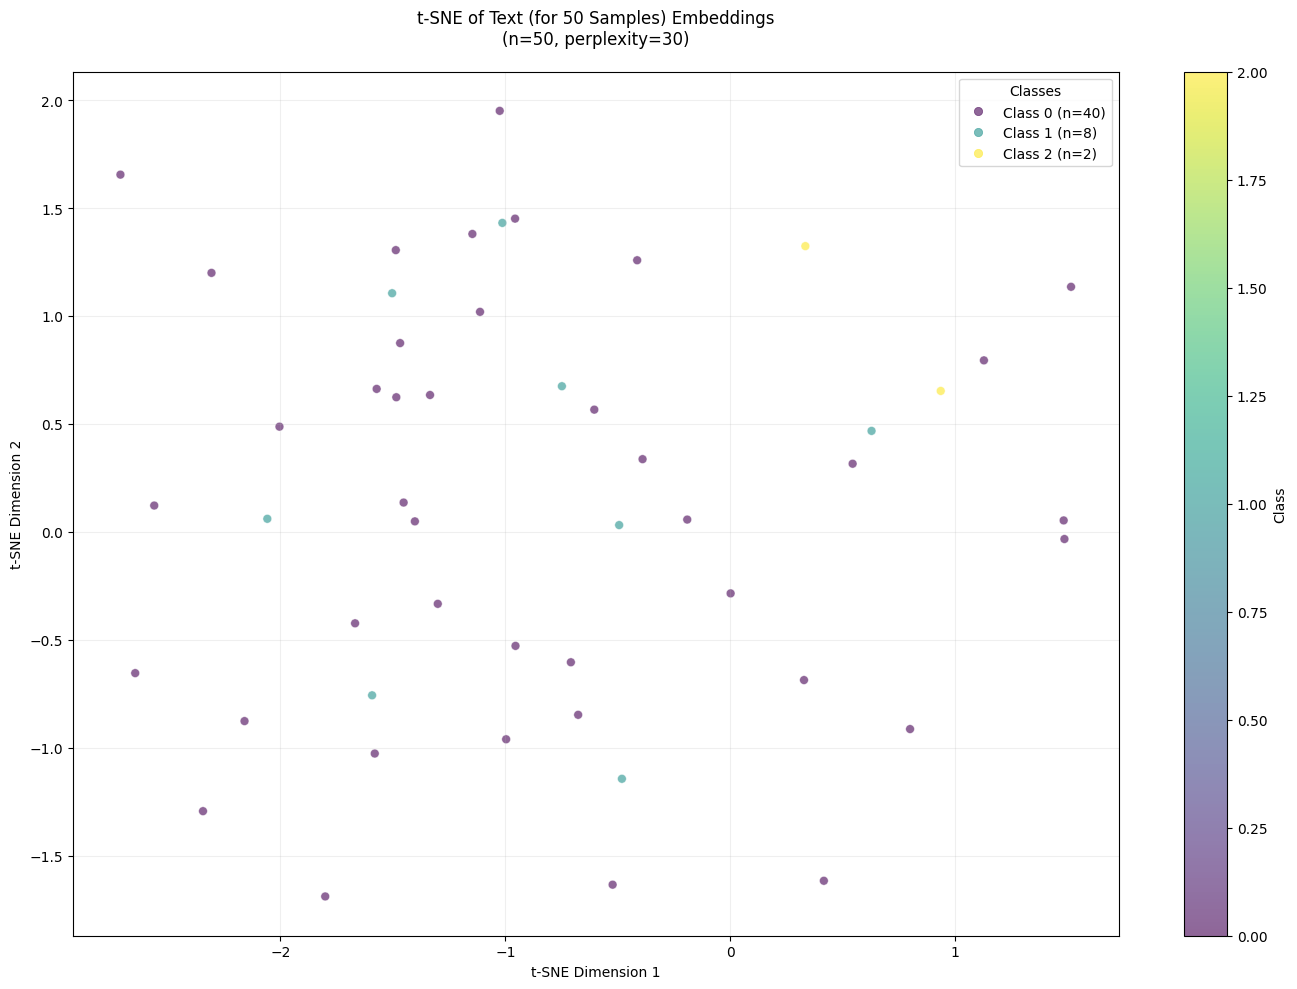


=== Image Embeddings ===

Class distribution for Image (for 50 Samples):
Class 0: 40 samples (80.0%)
Class 1: 8 samples (16.0%)
Class 2: 2 samples (4.0%)

Computing t-SNE for Image (for 50 Samples) embeddings...


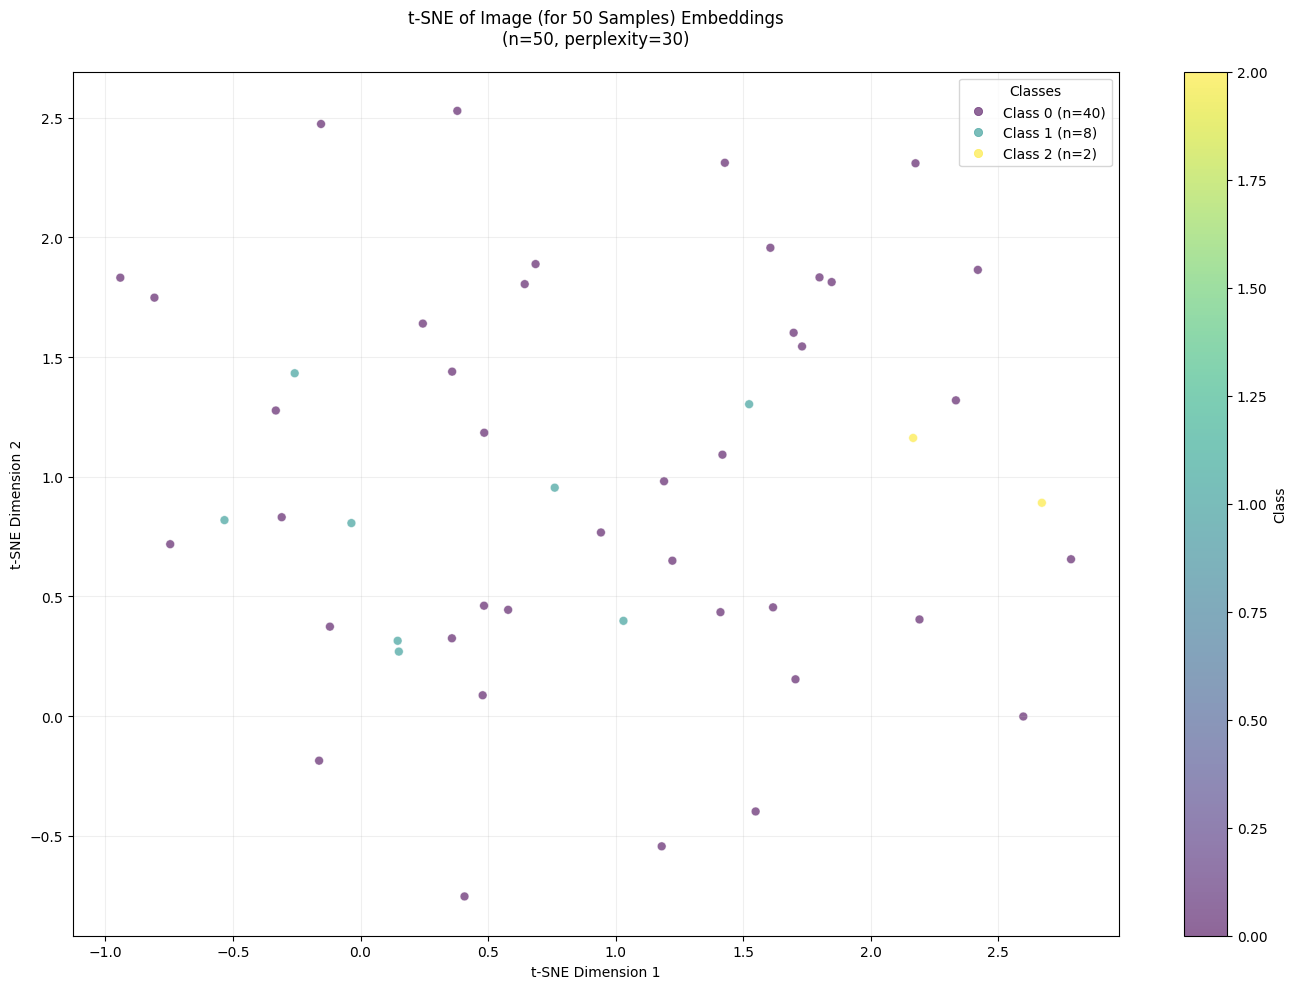


=== Multimodal Embeddings ===

Class distribution for Multimodal (for 50 Samples):
Class 0: 40 samples (80.0%)
Class 1: 8 samples (16.0%)
Class 2: 2 samples (4.0%)

Computing t-SNE for Multimodal (for 50 Samples) embeddings...


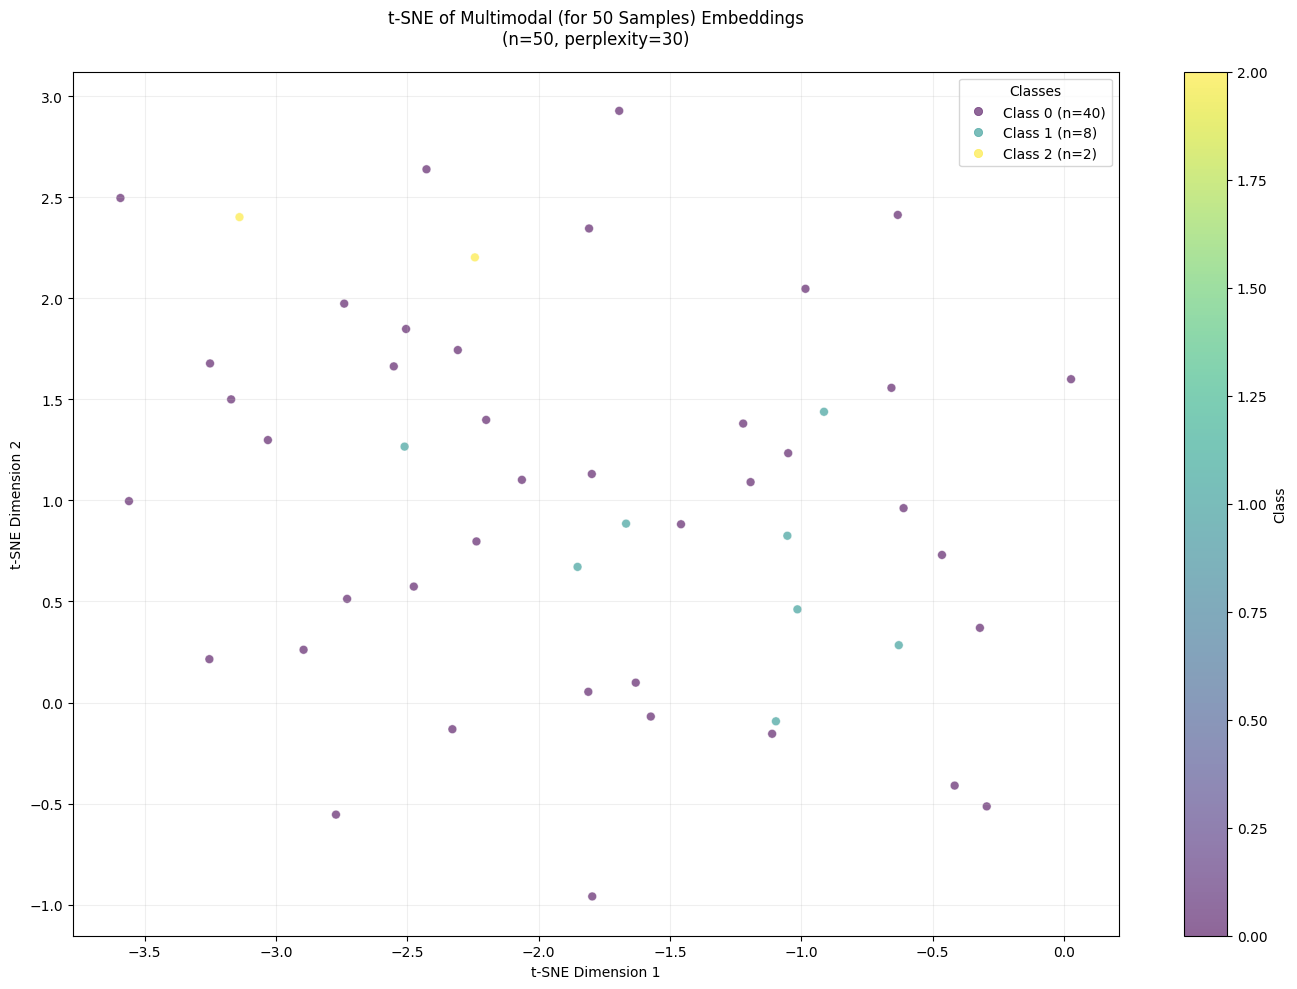

In [220]:
def plot_embeddings(embeddings, labels, title, n_samples=1000, perplexity=30):
    """Visualize embeddings using t-SNE with class distribution"""
    """plot_embeddings first for a general structure check."""
    # Convert to numpy if needed
    if isinstance(embeddings, torch.Tensor):
        embeddings = embeddings.numpy()
    if isinstance(labels, torch.Tensor):
        labels = labels.numpy()
    
    # Handle sample size
    n_samples = min(n_samples, len(embeddings))
    sample_indices = np.random.choice(len(embeddings), n_samples, replace=False)
    
    # Prepare data
    sample_embeddings = embeddings[sample_indices]
    sample_labels = labels[sample_indices]
    class_indices = np.argmax(sample_labels, axis=1)
    
    # Calculate class distribution
    unique_classes, class_counts = np.unique(class_indices, return_counts=True)
    print(f"\nClass distribution for {title}:")
    for cls, count in zip(unique_classes, class_counts):
        print(f"Class {cls}: {count} samples ({count/n_samples:.1%})")
    
    # Adaptive perplexity
    perplexity = min(perplexity, n_samples - 1)
    
    # Compute t-SNE
    tsne = TSNE(n_components=2, 
                perplexity=perplexity,
                random_state=42,
                n_iter=1000)
    
    print(f"\nComputing t-SNE for {title} embeddings...")
    reduced = tsne.fit_transform(sample_embeddings)
    
    # Plotting
    plt.figure(figsize=(14, 10))
    scatter = plt.scatter(reduced[:, 0], reduced[:, 1],
                         c=class_indices,
                         alpha=0.6,
                         cmap='viridis',
                         s=40,
                         edgecolors='w',
                         linewidths=0.5)
    
    plt.colorbar(scatter, label='Class')
    plt.title(f"t-SNE of {title} Embeddings\n(n={n_samples}, perplexity={perplexity})", pad=20)
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.grid(alpha=0.2)
    
    # Add legend with class counts
    handles, _ = scatter.legend_elements()
    legend_labels = [f"Class {i} (n={c})" for i, c in zip(unique_classes, class_counts)]
    plt.legend(handles, legend_labels, title="Classes")
    
    plt.tight_layout()
    plt.show()

# Load and visualize added with error handling
try:

    sample_data = torch.load(f"{Config.embed_save_dir}embeddings_0000_50samples.pt")
    
    # Visualize with enhanced function
    print("=== Text Embeddings ===")
    plot_embeddings(sample_data['text'], sample_data['labels'], "Text (for 50 Samples)")
    
    print("\n=== Image Embeddings ===")
    plot_embeddings(sample_data['image'], sample_data['labels'], "Image (for 50 Samples)")
    
    print("\n=== Multimodal Embeddings ===")
    plot_embeddings(sample_data['multimodal'], sample_data['labels'], "Multimodal (for 50 Samples)")
    
except FileNotFoundError:
    print("Error: Embeddings file not found. Please generate embeddings first.")
except Exception as e:
    print(f"An error occurred during visualization: {str(e)}")

### Verification of embeddings and sample print

In [221]:

# Loading the saved batch to check shapes
sample_batch = torch.load(f"{Config.embed_save_dir}embeddings_0000_50samples.pt")

print("Text embeddings shape:", sample_batch['text'].shape)
print("Image embeddings shape:", sample_batch['image'].shape)
print("Multimodal embeddings shape:", sample_batch['multimodal'].shape)
print("Labels shape:", sample_batch['labels'].shape)

print("Sample text embedding:", sample_batch['text'][0])
print("Sample image embedding:", sample_batch['image'][0])
print("Sample multimodal embedding:", sample_batch['multimodal'][0])



Text embeddings shape: torch.Size([50, 768])
Image embeddings shape: torch.Size([50, 2048])
Multimodal embeddings shape: torch.Size([50, 2816])
Labels shape: torch.Size([50, 3])
Sample text embedding: tensor([-4.3490e-02,  9.0693e-02, -6.2568e-02,  6.2915e-02, -1.5848e-01,
         1.9413e-02,  1.7723e-01,  2.5873e-01, -1.0360e-01,  3.1237e-02,
         2.9299e-02,  1.2436e-01,  3.5469e-02,  2.6762e-01, -9.4671e-03,
        -3.8718e-02, -1.1537e-01,  1.9274e-01,  2.0455e-01, -1.2292e-01,
        -8.3590e-02, -6.1021e-02, -1.5051e-01, -1.5047e-01,  9.9767e-03,
        -5.1243e-03, -3.7311e-02, -1.4269e-02,  3.1710e-03,  2.8384e-01,
        -9.1556e-03,  4.4559e-02, -6.6676e-03,  8.8726e-02, -2.4994e-02,
         7.7961e-02, -5.9776e-02, -2.0221e-02,  1.4187e-01,  2.0365e-02,
         1.6289e-01, -2.0973e-02,  2.7051e-01,  3.2304e-02, -9.8797e-02,
        -1.5179e-01, -1.4810e+00,  3.8217e-02, -2.4166e-01, -1.7398e-01,
        -1.9240e-02, -1.5461e-02,  8.5977e-02,  1.0896e-01, -1.2585e-

In [222]:
embeddings = torch.load(f"{Config.embed_save_dir}embeddings_0000_50samples.pt")
print(f"Number of samples in final file: {len(embeddings['text'])}")

Number of samples in final file: 50


### Visualization of embeddings with hate types color-coded to analyze the clustering of hate types

In [223]:
# Plotting function with hate types and error handling

def plot_hate_embeddings(embeddings, labels, title):
    """visualization with fallbacks"""
    """plot_hate_embeddings to analyze specific hate speech clusters."""
    try:
        # Convert inputs
        if isinstance(embeddings, torch.Tensor):
            embeddings = embeddings.numpy()
        if isinstance(labels[0], str):
            labels = [ast.literal_eval(x) for x in labels]
        
        # Validate shapes
        assert len(embeddings) == len(labels), "Mismatched lengths!"
        
        # Normalize embeddings (critical for t-SNE)
        embeddings = (embeddings - embeddings.mean(0)) / (embeddings.std(0) + 1e-8)
        
        # Simplified t-SNE with auto-perplexity
        perplexity = min(5, len(embeddings)-1)  # Very small for 50 samples
        tsne = TSNE(n_components=2, perplexity=perplexity, init='random')
        points = tsne.fit_transform(embeddings)
        
        # Create binary labels
        hate_types = ["Non-hate", "Racist", "Sexist", "Homophobe", "Religion", "Other"]
        label_matrix = np.zeros((len(labels), len(hate_types)))
        for i, lbl in enumerate(labels):
            for cat in lbl:
                label_matrix[i, cat] = 1
        
        # Plot each category
        plt.figure(figsize=(12,8))
        colors = ['gray', 'red', 'blue', 'green', 'purple', 'orange']
        
        for cat_idx, (color, name) in enumerate(zip(colors, hate_types)):
            mask = label_matrix[:, cat_idx] == 1
            if mask.sum() > 0:  # Only plot if samples exist
                plt.scatter(points[mask,0], points[mask,1], 
                           c=color, label=name, alpha=0.7)
        
        plt.legend()
        plt.title(f"{title} (n={len(embeddings)})")
        plt.show()
        
    except Exception as e:
        print(f"Plotting failed for {title}: {str(e)}")
        # Fallback - show raw data distribution
        plt.figure(figsize=(12,4))
        plt.hist(embeddings.flatten(), bins=50)
        plt.title(f"Embedding Value Distribution (Failed to plot {title})")
        plt.show()

Plotting failed for Text: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


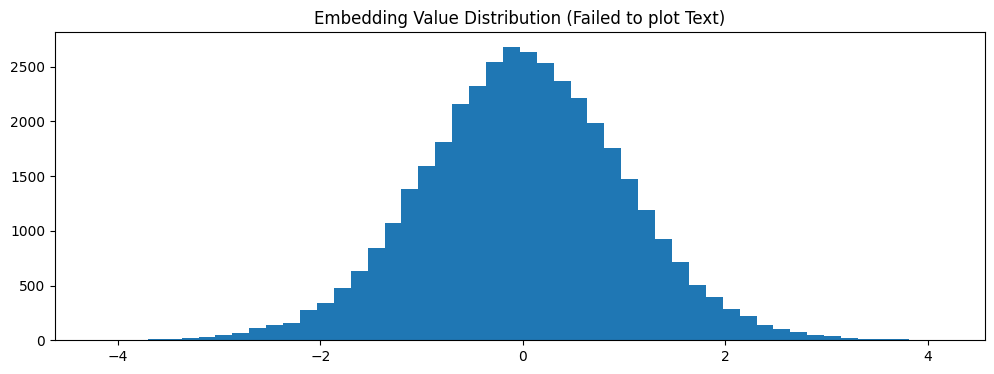

Plotting failed for Image: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


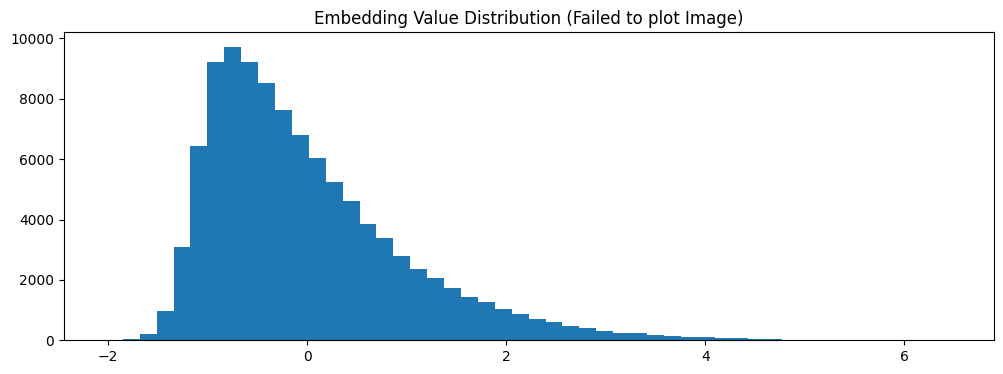

Plotting failed for Multimodal: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


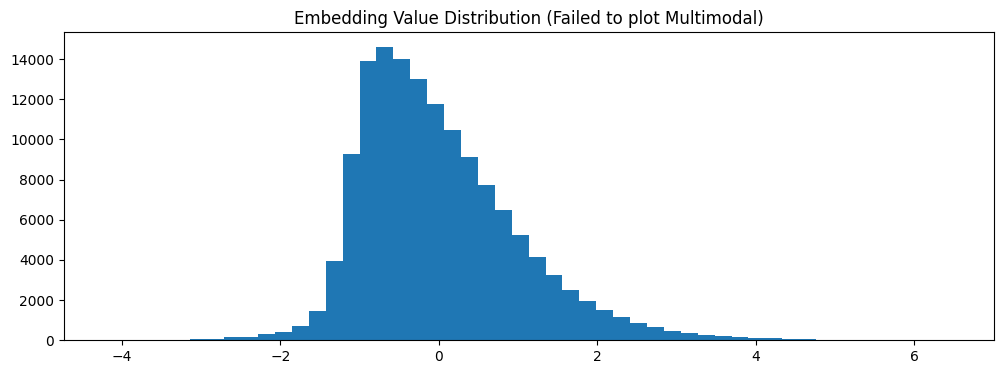

In [224]:
# Load data and test plotting function
sample_data = torch.load(f"{Config.embed_save_dir}embeddings_0000_50samples.pt")

# Plot with error handling
plot_hate_embeddings(sample_data['text'][:50], sample_data['labels'][:50], "Text")
plot_hate_embeddings(sample_data['image'][:50], sample_data['labels'][:50], "Image")
plot_hate_embeddings(sample_data['multimodal'][:50], sample_data['labels'][:50], "Multimodal")

### Diagnostic function to check embeddings and labels associated with its shape and size


=== Emergency Diagnostic ===
Total samples: 50

--- text embeddings ---
Shape: torch.Size([50, 768])
Mean: tensor(-0.0095)
STD: tensor(0.5166)
NaN: False
Inf: False


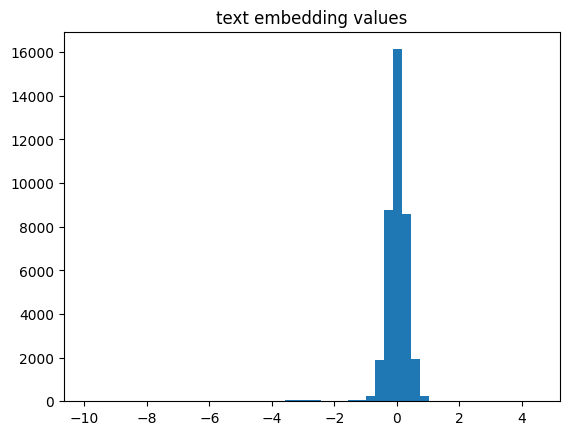


--- image embeddings ---
Shape: torch.Size([50, 2048])
Mean: tensor(0.4299)
STD: tensor(0.4089)
NaN: False
Inf: False


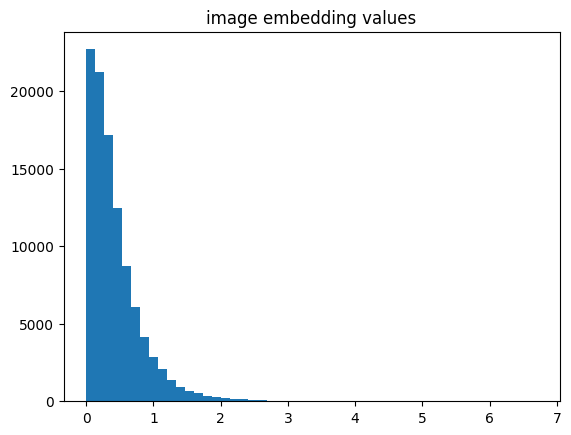


--- multimodal embeddings ---
Shape: torch.Size([50, 2816])
Mean: tensor(0.3100)
STD: tensor(0.4824)
NaN: False
Inf: False


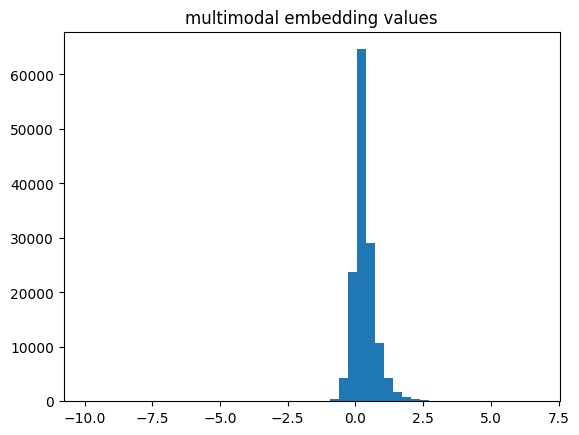


Label examples:
Sample 0: tensor([4., 1., 3.])
Sample 1: tensor([5., 5., 5.])
Sample 2: tensor([0., 0., 0.])
Sample 3: tensor([1., 0., 0.])
Sample 4: tensor([1., 0., 1.])

Label distribution:
Label Counts:
Class 0.0: 104 samples
Class 1.0: 21 samples
Class 2.0: 7 samples
Class 3.0: 9 samples
Class 4.0: 2 samples
Class 5.0: 7 samples


In [225]:

def emergency_diagnostic():
    data = torch.load(f"{Config.embed_save_dir}embeddings_0000_50samples.pt")
    
    print("=== Emergency Diagnostic ===")
    print(f"Total samples: {len(data['labels'])}")
    
    # Check embeddings
    for modality in ['text', 'image', 'multimodal']:
        print(f"\n--- {modality} embeddings ---")
        
        embeddings = data[modality]
        
        # Check if tensor is empty
        if embeddings.numel() == 0:
            print(" Warning: No embeddings found!")
            continue

        print("Shape:", embeddings.shape)
        print("Mean:", torch.mean(embeddings))
        print("STD:", torch.std(embeddings))
        print("NaN:", torch.isnan(embeddings).any().item())
        print("Inf:", torch.isinf(embeddings).any().item())
        
        # Remove NaN/Inf before plotting
        clean_embeddings = embeddings[torch.isfinite(embeddings)]
        
        if clean_embeddings.numel() > 0:
            plt.hist(clean_embeddings.numpy(), bins=50)
            plt.title(f"{modality} embedding values")
            plt.show()
        else:
            print("No valid values to plot.")

    # Check labels
    print("\nLabel examples:")
    for i in range(min(5, len(data['labels']))):
        print(f"Sample {i}: {data['labels'][i]}")
    
    print("\nLabel distribution:")
    
    all_labels = []
    for lbl in data['labels']:
        if isinstance(lbl, torch.Tensor):
            all_labels.extend(lbl.numpy().tolist())
        elif isinstance(lbl, str):
            try:
                parsed_lbl = ast.literal_eval(lbl)
                all_labels.extend(parsed_lbl if isinstance(parsed_lbl, list) else [parsed_lbl])
            except:
                print(f"⚠️ Error parsing label: {lbl}")

    unique_labels, counts = np.unique(all_labels, return_counts=True)
    
    # Print structured label distribution
    print("Label Counts:")
    for lbl, count in zip(unique_labels, counts):
        print(f"Class {lbl}: {count} samples")

emergency_diagnostic()


The following is the distribution of class labels in the dataset. Note that the total count may exceed the number of samples if multiple labels are assigned to a single sample.  

**Label Counts**:
- **Class 0**: 104 samples → Most frequent class  
- **Class 1**: 21 samples  
- **Class 2**: 7 samples  
- **Class 3**: 9 samples  
- **Class 4**: 2 samples → Least frequent class  
- **Class 5**: 7 samples  

**Meaning and representaion**
- The dataset is **multi-label**, meaning a single sample can belong to **multiple classes**.  
- The total number of label occurrences (104 + 21 + 7 + 9 + 2 + 7 = 150) is greater than the total number of samples (e.g., 50).  
- Some classes appear significantly more than others, which might indicate an **imbalance** in the dataset.  

